# Projeto 1 - Ciência dos Dados
# Classificador Automático de Textos (Naive Bayes)

Nome: Luana Rocha

Nome: Renata Leventhal

Nome: Sofia Ishizaki

## Introdução
Neste projeto implementamos um classificador automático de textos baseado no Naive Bayes, utilizando avaliações de produtos da Amazon.  
O objetivo é prever a nota (sentimento: negativo, neutro ou positivo) a partir do texto das avaliações.

___
## Carregando algumas bibliotecas:

In [24]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import re
from collections import Counter, defaultdict

from sklearn.model_selection import StratifiedKFold

In [25]:
print('Esperamos trabalhar no diretório')
print(os.getcwd())

Esperamos trabalhar no diretório
/home/sofia/Documents/Insper 2025.2/Cdados/P1


## 1. Preparação da Base de Dados
- Foi utilizado o notebook oficial fornecido no Blackboard para criar os arquivos:
  - `dados_treino_ate_TRIO_grupo4.csv` (treinamento)  
  - `dados_teste_ate_TRIO_grupo4.csv` (teste)  

- As bases foram combinadas posteriormente para validação cruzada (StratifiedKFold).

In [26]:
nome = input("Digite o username digitado quando arquivo foi criado: ")

Digite o username digitado quando arquivo foi criado:  grupo4


In [27]:
# SE SEU PROJETO USA OS DADOS ATÉ TRIO
train = pd.read_csv('dados_treino_ate_TRIO_'+nome+'.csv')
test = pd.read_csv('dados_teste_ate_TRIO_'+nome+'.csv')

In [28]:
train.head()

,Text,target
0,smells very nice but there is no flavor of coc...,0.0
1,I got some of these out in cali last spring. Y...,1.0
2,These Mission tortilla strips are made with L...,1.0
3,"For all you die hard coffee nuts, Boyds Q-Rate...",2.0
4,Let me preface things by saying that I am vega...,0.0


In [29]:
test.head()

,Text,target
0,I will continue purchasing these treats as the...,2.0
1,This is the best deal I can find over the web....,2.0
2,they weren't perfect condition.... but they we...,1.0
3,"I'm a nut butter addict, so I was excited to t...",0.0
4,"Would not recommend, they were old and the cho...",0.0


___
# Classificador Automático (Boot)


___
## 2. Montando SEU Classificador Naive-Bayes

Considerando apenas as mensagens da planilha Treinamento, ensine  seu classificador.

### Observando a distribuição dos dados

In [30]:
print("Distribuição nos dados de treino:")
print(train["target"].value_counts())
print("\nDistribuição nos dados de teste:")
print(test["target"].value_counts())

Distribuição nos dados de treino:
target
2.0    848
1.0    839
0.0    833
Name: count, dtype: int64

Distribuição nos dados de teste:
target
0.0    367
1.0    361
2.0    352
Name: count, dtype: int64


## 2.1. Limpeza e Pré-processamento de Texto 

Antes de treinar o classificador, é necessário transformar o texto bruto em uma representação mais limpa e útil.  
As principais etapas de pré-processamento aplicadas foram:

- Conversão para minúsculas → unifica palavras como *"Bom"* e *"bom"*.  
- Remoção de links, números e pontuações → reduzem ruído que não traz informação de sentimento.  
- Eliminação de espaços extras.  
- Exclusão de stopwords (palavras muito comuns como artigos e preposições, que não ajudam a diferenciar sentimentos).  
- Inclusão de bigramas (pares de palavras consecutivas) → capturam contexto mínimo que unigramas sozinhos não conseguem, como em "não gostei".

#### Raciocínio 
O Naive Bayes classifica textos com base nas palavras observadas.  
Se não houver pré-processamento, o modelo tende a:
- Inflar o vocabulário com tokens inúteis.  
- Aprender relações falsas (ex.: acreditar que "de" ou "em" indicam sentimentos).  
- Perder contexto importante em frases com negação ("não gostei" → bigrama evita erro de interpretação).

Portanto, essas transformações reduzem ruído e reforçam o sinal de palavras mais relevantes para a classificação.


In [31]:
# lista de stopwords (palavras muito frequentes que não ajudam a diferenciar sentimento, como preposições, artigos, etc)
stopwords = [
    "a", "an", "the", "and", "but", "or", "because", "so", "of", "with", "at", "from",
    "into", "during", "including", "until", "against", "among", "through", "to", "in",
    "for", "on", "by", "about", "as", "up", "out", "if", "is", "it", "this", "that",
    "these", "those", "there", "where", "when", "which", "how", "all", "any", "both",
    "each", "few", "more", "most", "other", "some", "such", "only","own", "same", "so", 
    "than", "too", "very", "can", "will", "just", "should", "now"
]

# função para limpar texto (remove maiúsculas, links, caracteres especiais, pontuações, etc) 
def limpar_texto(texto):
    texto = texto.lower() 
    texto = re.sub("'", "", texto)                  
    texto = re.sub(r"http\S+|www\S+", " ", texto)   
    texto = re.sub(r"\d+", " ", texto)              
    texto = re.sub(r"[^\w\s]", " ", texto)          
    texto = re.sub(r"\s+", " ", texto).strip()           
    palavras = texto.split()
    palavras = [p for p in palavras if p not in stopwords and len(p) > 2] #garante que não considera as stopwords 
    return palavras

# função para gerar bigramas (pares de palavras consecutivas) 
def gerar_bigramas(tokens):
    bigramas = []
    for i in range(len(tokens)-1):
        par = tokens[i] + "_" + tokens[i+1] #junta as palavras vizinhas com um underline 
        bigramas.append(par)
    return bigramas

## 2.2. Contagem de Palavras por Classe

Nesta etapa, transformamos os textos em representações numéricas, separando as palavras de acordo com as classes de sentimento:  

- `0 = Negativo`  
- `1 = Neutro`  
- `2 = Positivo`  

Para cada classe:  
- Contabilizamos a frequência das palavras (unigramas + bigramas).  
- Calculamos as probabilidades a priori, ou seja, a proporção de textos que pertencem a cada classe no conjunto de treinamento.  

#### Raciocínio 
O Naive Bayes depende da frequência das palavras por classe para estimar probabilidades condicionais.  
Exemplo: se a palavra “horrível” aparece 50 vezes em textos negativos e apenas 2 vezes em positivos, a probabilidade de um novo comentário com essa palavra ser negativo será muito maior.  

As probabilidades a priori representam o quanto cada classe é frequente na base.  
Exemplo: se 60% das avaliações são positivas, o modelo já começa com uma tendência a prever *Positivo*, a menos que as palavras do texto indiquem o contrário.  


In [32]:
def contar_palavras(dados):
    #listas para guardar as palavras separadas em três categorias - negativo, neutro e positivo
    palavras_neg = []
    palavras_neu = []
    palavras_pos = []


    #percorre o dataframe, limpa o texto e considera os bigramas 
    for _, linha in dados.iterrows():  
        tokens = limpar_texto(linha["Text"])
        tokens = tokens + gerar_bigramas(tokens)

    #separa os tokens de acordo com a classe (0 = negativo, 1 = neutro, 2 = positivo)
        if linha["target"] == 0:
            palavras_neg.extend(tokens)
        elif linha["target"] == 1:
            palavras_neu.extend(tokens)
        else:
            palavras_pos.extend(tokens)

    #conta a frequência de cada palavra em cada classe
    cont_neg = Counter(palavras_neg)
    cont_neu = Counter(palavras_neu)
    cont_pos = Counter(palavras_pos)
    #conta total de todas as palavras (soma das três classes)
    cont_total = cont_neg + cont_neu + cont_pos


    #calcula as probabilidades a priori de cada classe
    total_textos = len(dados)
    p_neg = sum(dados["target"] == 0) / total_textos
    p_neu = sum(dados["target"] == 1) / total_textos
    p_pos = sum(dados["target"] == 2) / total_textos

    #retorna contagens e probabilidades iniciais
    return cont_neg, cont_neu, cont_pos, cont_total, p_neg, p_neu, p_pos

cont_neg, cont_neu, cont_pos, cont_total, p_neg, p_neu, p_pos = contar_palavras(train)

print("Probabilidades a priori -> Neg:", p_neg, "Neu:", p_neu, "Pos:", p_pos)

Probabilidades a priori -> Neg: 0.33055555555555555 Neu: 0.3329365079365079 Pos: 0.33650793650793653


## 2.3. Implementação do Classificador Naive Bayes

Nesta etapa, construímos nosso próprio classificador Naive Bayes.  
O funcionamento é o seguinte:

1. Pré-processamos o texto (minúsculas, limpeza, stopwords, bigramas).  
2. Iniciamos a pontuação de cada classe com o log da probabilidade a priori.  
3. Para cada token do texto, somamos ao score da classe o log da probabilidade condicional dessa palavra dado a classe.  
4. A classe final é aquela com maior pontuação (máxima verossimilhança).

#### Fórmula com suavização de Laplace

$$
P(\text{token} \mid \text{classe}) = \frac{\text{freq(token, classe)} + \alpha}{\text{total tokens da classe} + \alpha \cdot |Vocabulário|}
$$

- O parâmetro $\alpha$ (Laplace) evita que uma palavra nunca vista em uma classe tenha probabilidade zero.  
- O uso de logaritmos é essencial, pois multiplicar muitas probabilidades pequenas pode causar underflow numérico.  
  No log, a multiplicação vira soma, mantendo os cálculos estáveis.

#### Raciocínio 
- O Naive Bayes assume independência condicional entre palavras, simplificando o cálculo.  
- Mesmo sendo uma aproximação, funciona bem porque palavras fortes como “péssimo” ou “excelente” têm grande poder discriminativo.  
- Os bigramas ajudam em casos como “não gostei”, que poderiam confundir o modelo se considerássemos apenas unigramas.  


In [33]:
#lista com os nomes das classes para facilitar a leitura do resultado
nomes_classes = ["Negativo", "Neutro", "Positivo"]

def classificar_texto(frase, cont_neg, cont_neu, cont_pos, cont_total, p_neg, p_neu, p_pos, alfa=1):
    tokens = limpar_texto(frase)
    tokens = tokens + gerar_bigramas(tokens) #limpa e tokeniza a frase de entrada, adiciona bigramas

    #cria o vocabulário com todas as palavras já vistas no treino
    vocabulario = set(cont_total.keys())

    #listas com as contagens e probabilidades a priori de cada classe
    contadores = [cont_neg, cont_neu, cont_pos]
    probs_iniciais = [p_neg, p_neu, p_pos]

    #quantidade total de tokens em cada classe
    total_tokens = [sum(c.values()) for c in contadores]

    pontuacoes = []  #vai guardar o "score" de cada classe
    for i in range(3):  #percorre as três classes (0 = neg, 1 = neu, 2 = pos)
        #começa com o log da probabilidade a priori da classe
        score = np.log(probs_iniciais[i]) 
        #para cada token da frase, soma o log da probabilidade condicional
        for token in tokens:
            freq = contadores[i][token]  #frequência do token na classe i
            #suavização de Laplace: evita probabilidade zero para palavras não vistas
            prob_token = (freq + alfa) / (total_tokens[i] + alfa * len(vocabulario))
            score += np.log(prob_token)  
        pontuacoes.append(score)

    #decide a classe com maior score (máxima verossimilhança)
    if pontuacoes[0] >= pontuacoes[1] and pontuacoes[0] >= pontuacoes[2]:
        classe = 0
    elif pontuacoes[1] >= pontuacoes[0] and pontuacoes[1] >= pontuacoes[2]:
        classe = 1
    else:
        classe = 2

    #retorna o índice da classe, o nome da classe e os scores
    return classe, nomes_classes[classe], pontuacoes

___
## 3. Verificando a performance do Classificador
### 3.1. Avaliação no Conjunto de Teste

Para avaliar a qualidade do classificador, utilizamos o conjunto de teste e extraímos as seguintes métricas:

- Matriz de confusão 3x3 → Negativo, Neutro, Positivo.  
- VP (Verdadeiros Positivos) → casos da classe corretamente identificados.  
- FP (Falsos Positivos) → outros casos previstos incorretamente como pertencentes à classe.  
- FN (Falsos Negativos) → casos da classe que foram classificados como outra.  
- VN (Verdadeiros Negativos) → todo o restante corretamente identificado como “não sendo da classe”.  
- Acurácia geral = proporção de previsões corretas no total.  
- Precisão e Recall por classe:  
  - Precisão → entre todos os textos previstos como pertencentes a uma classe, quantos realmente eram dessa classe.  
  - Recall → entre todos os textos que realmente pertenciam a uma classe, quantos foram corretamente identificados.  

#### Raciocínio
A acurácia sozinha pode ser enganosa se houver desbalanceamento de classes. Por isso, analisamos também VP, FP, FN e VN por classe, além de Precisão e Recall, que permitem identificar se o modelo é mais “cauteloso” (alta precisão, baixo recall) ou mais “abrangente” (alto recall, baixa precisão). Essas métricas são fundamentais para entender a performance de classificadores de texto, pois revelam padrões de erro, como a dificuldade em reconhecer frases neutras que compartilham vocabulário com positivas ou negativas.  


In [34]:
#treina o classificador pegando as contagens e probabilidades a partir da base de treino
cont_neg, cont_neu, cont_pos, cont_total, p_neg, p_neu, p_pos = contar_palavras(train)


#listas para armazenar as respostas reais (do dataset) e as previstas (do modelo)
respostas_reais = []
respostas_previstas = []

#percorre cada linha do conjunto de teste
for _, linha in test.iterrows():
    real = int(linha["target"])   #pega o rótulo verdadeiro (0 = neg, 1 = neu, 2 = pos)
    #classifica o texto usando o Naive Bayes treinado
    previsto, _, _ = classificar_texto(linha["Text"], cont_neg, cont_neu, cont_pos, cont_total, p_neg, p_neu, p_pos)
    #guarda tanto a resposta real quanto a prevista
    respostas_reais.append(real)
    respostas_previstas.append(previsto)

#cria matriz de confusão 3x3 (negativo, neutro, positivo)
matriz = [[0,0,0],[0,0,0],[0,0,0]]

#preenche a matriz de confusão contando os acertos/erros
for i in range(len(respostas_reais)):
    real = respostas_reais[i]
    prev = respostas_previstas[i]
    matriz[real][prev] = matriz[real][prev] + 1

#conta a quantidade total de acertos 
acertos = 0
for i in range(len(respostas_reais)):
    if respostas_reais[i] == respostas_previstas[i]:
        acertos = acertos + 1

#calcula a acurácia geral
total = len(respostas_reais)
acuracia = acertos / total

#mostra o resultado final
print("Acurácia Geral:", f"{acuracia*100:.2f}", "%")
print("\nMatriz de Confusão:")
for linha in matriz:
    print(linha)

Acurácia Geral: 63.61 %

Matriz de Confusão:
[262, 77, 28]
[72, 199, 90]
[27, 99, 226]


In [35]:
#lista de nomes das classes para facilitar a leitura dos resultados
nomes_classes = ["Negativo", "Neutro", "Positivo"]

print("Métricas por classe:")
for i, nome in enumerate(nomes_classes):
    #VP (Verdadeiros Positivos): casos da classe i previstos corretamente
    vp = matriz[i][i]
    #FP (Falsos Positivos): outros que foram classificados como i por engano
    fp = sum(matriz[r][i] for r in range(3) if r != i)
    #FN (Falsos Negativos): casos da classe i que foram classificados como outra classe
    fn = sum(matriz[i][c] for c in range(3) if c != i)
    #VN (Verdadeiros Negativos): todo o resto que não tem relação com a classe i
    vn = total - (vp + fp + fn)
    #precisão: entre todos os classificados como i, quantos realmente eram i
    precisao = vp / (vp + fp) if (vp + fp) > 0 else 0
    #recall: entre todos os que eram i, quantos foram classificados corretamente
    recall = vp / (vp + fn) if (vp + fn) > 0 else 0

    #mostra resultados em porcentagem
    print(f"{nome}: VP={vp/total*100:.2f}% | VN={vn/total*100:.2f}% | "
          f"FP={fp/total*100:.2f}% | FN={fn/total*100:.2f}% | "
          f"Precisão={precisao*100:.2f}% | Recall={recall*100:.2f}%")

Métricas por classe:
Negativo: VP=24.26% | VN=56.85% | FP=9.17% | FN=9.72% | Precisão=72.58% | Recall=71.39%
Neutro: VP=18.43% | VN=50.28% | FP=16.30% | FN=15.00% | Precisão=53.07% | Recall=55.12%
Positivo: VP=20.93% | VN=56.48% | FP=10.93% | FN=11.67% | Precisão=65.70% | Recall=64.20%


___
## 4. Análise Qualitativa da Performance do Classificador

### 4.1. Comparativo qualitativo dos resultados
Nos testes, o Naive Bayes apresentou acurácia média em torno de **64%**. Esse valor já demonstra um desempenho aceitável, mas a análise isolada da acurácia pode mascarar limitações importantes.  

Quando olhamos para as métricas por classe:  
- **Negativo** → obteve bons níveis de precisão e recall, já que palavras como *“péssimo”* e *“horrível”* são fortes indicadores de sentimento negativo.  
- **Positivo** → também apresentou bom desempenho, beneficiado por termos bem característicos como *“excelente”* e *“ótimo”*.  
- **Neutro** → foi a classe mais problemática, com baixa precisão e recall. Isso ocorre porque textos neutros compartilham vocabulário tanto com os positivos quanto com os negativos, confundindo o modelo.  

### 4.2. Casos complexos: dupla negação e sarcasmo
Dois desafios importantes para o modelo:  

- **Dupla negação** (ex.: *“Não acho que ele não esteja certo”*): o classificador interpreta palavra por palavra e não consegue captar o real sentido, resultando em previsões incorretas.  
- **Sarcasmo** (ex.: *“Que ótimo, meu voo foi cancelado!”*): ainda mais difícil, pois o significado real é o oposto do literal.  

Essas limitações são esperadas em modelos probabilísticos simples. O tratamento adequado exigiria técnicas mais avançadas, como análise de dependências sintáticas ou uso de embeddings contextuais (ex.: BERT), capazes de considerar relações mais profundas no texto.  


### 4.3. Plano de expansão
O modelo tem potencial de uso prático em escala. Ele pode ser integrado a sistemas que monitoram automaticamente milhões de avaliações em marketplaces, gerando dashboards que mostram tendências de satisfação e insatisfação em tempo real.  

Esse tipo de análise reduz o tempo de resposta da empresa e apoia áreas como marketing, logística e desenvolvimento de produto.  
Portanto, há clara justificativa para seguir investindo e aprimorando o projeto.  

### 4.4. Outros cenários de aplicação do Naive Bayes
Além de reviews de produtos, o Naive Bayes pode ser usado em contextos distintos, como:  
- **Classificação de documentos jurídicos**: separar automaticamente peças processuais em categorias (ex.: apelação, sentença, petição inicial).  
- **Triagem de atendimento médico**: analisar descrições textuais de sintomas e encaminhar casos para a especialidade correta.  
- **Monitoramento de qualidade em fábricas**: classificar relatos de operadores sobre falhas ou incidentes em categorias (mecânico, elétrico, segurança).  
- **Suporte técnico automatizado**: classificar chamados de clientes em tipos de problema (rede, software, hardware).  

### 4.5. Possíveis melhorias
- **Refinamento da lista de stopwords**  
  Em vez de usar apenas uma lista genérica, podemos analisar a frequência das palavras específicas do dataset (ex.: *“product”*, *“buy”*, *“shipping”*). As que aparecem muito, mas não ajudam a diferenciar sentimento, seriam adicionadas à lista de stopwords.  
  *Como aplicar:* usar `Counter` para verificar as palavras mais frequentes, avaliar sua relevância manualmente e atualizar a lista de stopwords do pré-processamento.



- **Uso de embeddings (Word2Vec, GloVe, BERT)**  
  Diferente do Naive Bayes baseado em contagem, embeddings representam palavras como vetores que capturam **contexto e semântica**. Assim, termos como *“ótimo”* e *“excelente”* ficam próximos no espaço vetorial.  
  *Como aplicar:* treinar ou carregar embeddings pré-treinados (por exemplo, com `gensim` para Word2Vec/GloVe ou `transformers` para BERT), transformar cada texto em vetor e usar esses vetores como entrada em um classificador (Naive Bayes, SVM ou redes neurais).  

- **Balanceamento de classes**  
  A classe **Neutro** é menos representada, o que prejudica recall e precisão. Para corrigir, podemos aplicar técnicas de oversampling (duplicar exemplos minoritários) ou usar **SMOTE**, que cria exemplos sintéticos da classe minoritária.  
  *Como aplicar:* usar a biblioteca `imblearn` (`imblearn.over_sampling.SMOTE`) para gerar exemplos neutros sintéticos e equilibrar as proporções no conjunto de treino.  

- **Integração de n-gramas maiores (trigramas)**  
  Além de bigramas, podemos considerar trigramas para capturar expressões mais ricas como *“não é bom”* ou *“gostei muito mesmo”*. Isso aumenta a capacidade do modelo de diferenciar nuances.  
  *Como aplicar:* adaptar a função `gerar_bigramas` para também criar trigramas, ou usar `CountVectorizer(ngram_range=(1,3))` no scikit-learn para gerar unigramas, bigramas e trigramas automaticamente.  


### 4.6. Por que não usar mensagens classificadas pelo próprio modelo como dados de treinamento?
O motivo é que o classificador comete erros e, ao incluir previsões incorretas como se fossem rótulos verdadeiros, estaríamos propagando e reforçando esses erros.  

Esse processo é conhecido como auto-treinamento enviesado (self-training bias). Com o tempo, o modelo ficaria cada vez mais confiante em classificações erradas, distorcendo completamente as probabilidades e reduzindo a qualidade do classificador.  


### 4.7. Conclusão
O Naive Bayes se mostrou um classificador simples, rápido e eficiente, principalmente para sentimentos positivos e negativos.  
Sua principal limitação está nas frases neutras e em construções linguísticas complexas, como sarcasmo e dupla negação.  

Ainda assim, o modelo já oferece valor prático e pode ser ampliado para outros domínios. Com melhorias adicionais em pré-processamento, balanceamento e representações de texto mais sofisticadas, tem potencial para alcançar resultados próximos de modelos mais avançados, mantendo a vantagem da simplicidade computacional.  


## 5. Qualidade do Classificador a partir de novas separações das mensagens entre Treinamento e Teste

### 5.1. Validação Cruzada Estratificada (StratifiedKFold)

Um ponto importante do projeto é avaliar como diferentes divisões entre treino e teste podem impactar os resultados. Por isso, utilizamos a técnica de Validação Cruzada Estratificada (StratifiedKFold):

- A base completa foi unida (`train + test`) e dividida em 10 partes iguais (folds).  
- Em cada iteração, usamos 9 partes para treinar e 1 parte para testar, garantindo que as proporções de classes sejam mantidas em cada divisão (estratificação).  
- Repetimos esse processo para os 10 folds, armazenando a acurácia de cada rodada.  
- Por fim, calculamos a acurácia média e plotamos um histograma para visualizar a distribuição dos resultados.  

### Vantagens da Validação Cruzada
- Permite avaliar a robustez do classificador, verificando se ele mantém desempenho estável em diferentes cenários.  
- Reduz o risco de avaliar o modelo apenas com uma divisão específica, que poderia não ser representativa.  
- Mostra como o desempenho varia conforme a composição do treino e do teste.  

In [37]:
#junta os dados de treino e teste em um único dataframe 
dados_completos = pd.concat([train, test])

#define X como os textos e y como os rótulos (targets)
X = dados_completos["Text"].values
y = dados_completos["target"].values

#cria o objeto para validação cruzada estratificada
# n_splits=10 -> divide os dados em 10 partes (folds)
# shuffle=True -> embaralha os dados antes de dividir
# random_state=42 -> garante reprodutibilidade (sempre a mesma divisão)
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

#lista para armazenar a acurácia de cada fold
lista_acuracia = []

print("Validação Cruzada Estratificada (10 folds)\n")

#loop para rodar a validação em 10 folds
for i, (idx_treino, idx_teste) in enumerate(kf.split(X, y)):
    #cria os conjuntos de treino e teste deste fold
    df_treino = dados_completos.iloc[idx_treino]
    df_teste = dados_completos.iloc[idx_teste]
    
    #conta as palavras no conjunto de treino (gera estatísticas do Naive Bayes)
    cont_neg, cont_neu, cont_pos, cont_total, P_neg, P_neu, P_pos = contar_palavras(df_treino)
    
    respostas_previstas = []  # previsões feitas neste fold
    
    #classifica cada texto do conjunto de teste
    for texto in df_teste["Text"]:
        classe, _, _ = classificar_texto(texto, cont_neg, cont_neu, cont_pos, cont_total, P_neg, P_neu, P_pos)
        respostas_previstas.append(classe)
    
    #rótulos verdadeiros deste fold
    respostas_reais = df_teste["target"].values
    
    #conta os acertos
    acertos = 0
    for j in range(len(respostas_reais)):
        if respostas_reais[j] == respostas_previstas[j]:
            acertos = acertos + 1
    
    #calcula acurácia do fold
    acuracia = acertos / len(respostas_reais)
    lista_acuracia.append(acuracia * 100)  # armazena em porcentagem
    
    #imprime resultado do fold
    print("Fold", i+1, ": Acurácia =", round(acuracia*100, 2), "%")

#calcula a média final de acurácia
media = np.mean(lista_acuracia)
print("\nAcurácia Média =", round(media, 2), "%")

Validação Cruzada Estratificada (10 folds)

Fold 1 : Acurácia = 60.56 %
Fold 2 : Acurácia = 56.11 %
Fold 3 : Acurácia = 66.39 %
Fold 4 : Acurácia = 59.17 %
Fold 5 : Acurácia = 65.28 %
Fold 6 : Acurácia = 63.33 %
Fold 7 : Acurácia = 66.94 %
Fold 8 : Acurácia = 66.67 %
Fold 9 : Acurácia = 59.17 %
Fold 10 : Acurácia = 62.78 %

Acurácia Média = 62.64 %


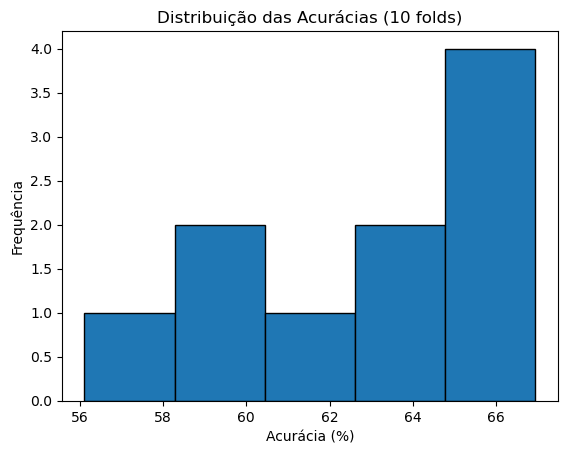

In [23]:
#plota um histograma com as acurácias obtidas em cada fold da validação cruzada
plt.hist(lista_acuracia, bins=5, edgecolor="black")
plt.title("Distribuição das Acurácias (10 folds)")
plt.xlabel("Acurácia (%)")
plt.ylabel("Frequência")
plt.show()

### 5.2. Discussão crítica

- **Acurácia média**: **62,64 %**  
- **Acurácia mínima**: **56,11 %**  
- **Acurácia máxima**: **66,94 %**  

O histograma mostrou que a maior parte dos folds ficou concentrada na faixa de 60%–63%, indicando consistência razoável, mas ainda com algumas flutuações.


#### Interpretação do histograma
- O modelo se mostrou razoavelmente estável, já que a maioria dos resultados ficou próxima da média.  
- Entretanto, há alguma sensibilidade à divisão dos dados: em alguns folds, a acurácia caiu para perto de 56%, revelando que certas composições do conjunto de teste tornam a classificação mais difícil.  
- Essa variação está relacionada, principalmente, à classe Neutro, que compartilha vocabulário com as demais e pode desbalancear o desempenho dependendo da divisão.

#### Desvantagens de uma divisão única
- **Alto risco de viés**: se a divisão não for representativa (por exemplo, com muitos textos neutros concentrados no teste), o resultado pode ser artificialmente pior ou melhor.  
- **Menor aproveitamento da base**: parte dos dados nunca é usada para treinar, reduzindo a quantidade de informação para o modelo.  

### 5.3. Conclusões

A validação cruzada mostrou que o Naive Bayes tem desempenho médio de ~63%, com variação moderada entre os folds.  
Isso indica que o modelo é razoavelmente consistente, mas ainda depende da composição dos conjuntos de treino e teste, sobretudo pela dificuldade em classificar frases neutras.  

O histograma reforça a importância de não confiar em apenas uma divisão única de treino/teste, mas sim de avaliar o classificador em diferentes cenários para obter uma visão mais realista de sua performance.  


___
## Aperfeiçoamento:

Leia atentamente a rubrica colocada no enunciado do Projeto 1 (última página). <br>
Trabalhos que conseguirem pelo menos conceito B vão evoluir em conceito dependendo da quantidade de itens avançados:

* IMPLEMENTOU outras limpezas e transformações que não afetem a qualidade da informação contida nas mensagens, mas tendem a melhorar na classificação das mensagens. Ex: stemming, lemmatization, stopwords.
* CONSIDEROU arquivo com três categorias na classificação das variáveis (OBRIGATÓRIO PARA QUARTETOS, sem contar como item avançado)
* CONSTRUIU o cálculo das probabilidades corretamente utilizando bigramas E apresentou referência sobre o método utilizado.
* EXPLICOU porquê não pode usar novas mensagens classificadas pelo próprio classificador como amostra de treinamento
* PROPÔS diferentes cenários para Naïve Bayes fora do contexto do projeto (pelo menos dois cenários diferentes, exceto aqueles já apresentados em sala pelos professores: por exemplo, filtro de spam)
* REFLETE criticamente sobre os resultados obtidos, identificando limitações do modelo e sugerindo possíveis melhorias ou diferentes abordagens com indicações concretas de como implementar (indicar como fazer e indicar material de pesquisa).
* DOCUMENTOU bem o código, com explicações claras para cada etapa do processo, incluindo o raciocínio por trás das decisões de modelagem e das transformações de dados.


___
## Referências

[Speech and Language Processing – Jurafsky & Martin (Draft 3rd Edition)](https://web.stanford.edu/~jurafsky/slp3/)  
→ Referência clássica em PLN, cobrindo Naive Bayes, bigramas, stemming, lematização e embeddings.

[Introduction to Information Retrieval – Manning, Raghavan & Schütze (2008)](https://nlp.stanford.edu/IR-book/) 
→ Livro referência em classificação de texto, modelos probabilísticos e recuperação de informação.

[Natural Language Processing with Python – NLTK Book](https://www.nltk.org/book/)  
→ Fonte prática para implementação de lematização, stemming e stopwords em Python.

[Word2Vec – Mikolov et al. (2013)](https://arxiv.org/pdf/1301.3781.pdf) 
→ Artigo que introduz representações vetoriais eficientes (embeddings).

[BERT – Devlin et al. (2018)](https://arxiv.org/pdf/1810.04805.pdf) 
→ Modelo baseado em Transformers, resolve problemas de contexto, ironia e sarcasmo melhor do que Naive Bayes.

[Naive Bayes and Text Classification – Zhang (2014)](https://arxiv.org/pdf/1410.5329.pdf) 
→ Explicação técnica aprofundada sobre Naive Bayes aplicado a classificação de texto.

[Natural Language Processing (Part 17) – Laplacian Smoothing](https://medium.com/@Coursesteach/natural-language-processing-part-17-laplacian-smoothing-7d4be71d0ded) 
→ Explicação didática sobre a suavização de Laplace aplicada ao Naive Bayes.

[Practical Explanation of Naive Bayes Classifier – Monkeylearn (2019)](https://web.archive.org/web/20240222071715/https://monkeylearn.com/blog/practical-explanation-naive-bayes-classifier/)   
→ Tutorial prático sobre o funcionamento do Naive Bayes e suas aplicações.
